<a href="https://colab.research.google.com/github/Jimbo994/gps-and-mtpgs-in-numpy-and-scipy/blob/main/GaussianProccessInNumpyAndScipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
# Training
length_scale = 1
sigma_f = 1.0
noise = 5
jitter = 1e-10

# Initial values for the hyperparameters
initial_params = [1, 1, 0.1]

n_train_points = 20
n_test_points = 50

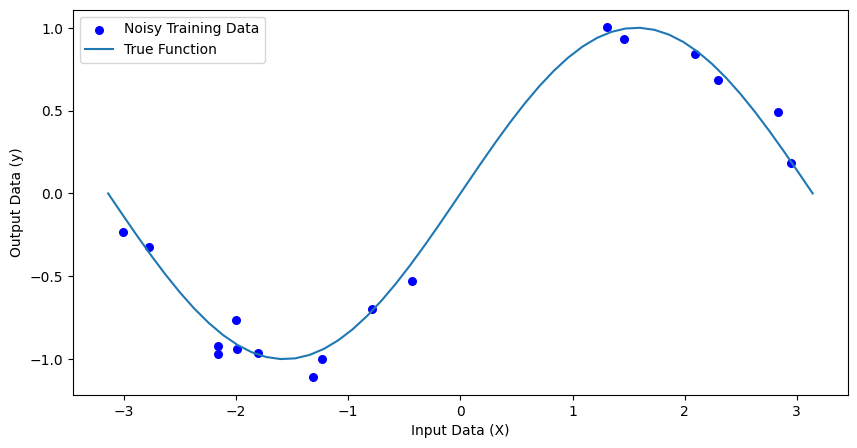

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate test input data
X_test = np.linspace(-np.pi, np.pi, n_test_points).reshape(-1, 1)

# Apply the sine function to generate test output data
y_test = np.sin(X_test)

# # Optionally, you can add some noise to the test output data
# noise = 0.1 * np.random.randn(*y_test.shape)
# y_test_noisy = y_test + noise

# Original training data
X_train_full = np.random.uniform(-np.pi, np.pi, n_train_points)
X_train_full = np.sort(X_train_full, axis=0)
y_train_full = np.sin(X_train_full)

# Filter out points where x is between 0 and 1
mask = (X_train_full > 0) ^ (X_train_full < 1)
X_train = X_train_full[mask].reshape(-1, 1)
y_train = y_train_full[mask]

# Continue with the rest of the GP process using X_train and y_train

# Add some noise to the training output data to simulate real-world data
noise = 0.1 * np.random.randn(*y_train.shape)
y_train_noisy = y_train + noise

# Plot the training data
plt.figure(figsize=(10, 5))
# plt.plot(X_train_full, y_train_full, label='True Function', linestyle='--')
plt.scatter(X_train, y_train_noisy, color='blue', label='Noisy Training Data', s=30)

# Plot the test data
plt.plot(X_test, y_test, label='True Function')
# plt.scatter(X_test, y_test_noisy, color='red', label='Noisy Test Data', s=10)
plt.legend()
plt.xlabel('Input Data (X)')
plt.ylabel('Output Data (y)')
# plt.title('Test Data from a Sine Function')
plt.show()


In [ ]:
import numpy as np
from scipy.linalg import cholesky, cho_solve
from scipy.optimize import minimize

# Define the RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Computes the RBF (Gaussian) kernel between two sets of input points.
    """
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

def icm_kernel(X1, X2, task_index_1, task_index_2, B, length_scale, sigma_f):
    base_kernel = rbf_kernel(X1, X2, length_scale, sigma_f)
    return base_kernel * B[task_index_1, task_index_2]


class GP:
    def __init__(self, X_train, y_train, kernel, initial_params):
        self.X_train = X_train
        self.y_train = y_train
        self.kernel = kernel
        self.K = None
        self.L = None
        self.params = initial_params
        self.log_likelihood = None

    def log_marginal_likelihood(self, params):
        length_scale, sigma_f, noise = params
        self.K = self.kernel(self.X_train, self.X_train, length_scale, sigma_f) + noise**2 * np.eye(len(self.X_train))
        jitter = 1e-10
        self.L = cholesky(self.K + jitter * np.eye(self.K.shape[0]), lower=True)
        # Compute the log marginal likelihood
        S1 = solve_triangular(self.L, self.y_train, lower=True)
        S2 = solve_triangular(self.L, S1, lower=True, trans='T')
        log_likelihood = -0.5 * np.dot(self.y_train.flatten(), S2)
        log_likelihood -= np.sum(np.log(np.diag(self.L)))
        log_likelihood -= len(self.X_train) / 2 * np.log(2 * np.pi)
        self.params = params  # Store the parameters
        self.log_likelihood = log_likelihood
        return -log_likelihood

    def predict(self, X_test):
        length_scale, sigma_f, noise = self.params

        # Check if we optimized model already
        if self.K is None or self.L is None:
            self.K = self.kernel(self.X_train, self.X_train, length_scale, sigma_f) + noise**2 * np.eye(len(self.X_train))
            self.L = cholesky(self.K + jitter * np.eye(self.K.shape[0]), lower=True)
            print("Warning: You have not optimized the model before predicting.")
        # Kernel of the test points and the training points
        K_s = self.kernel(X_test, self.X_train, length_scale, sigma_f)

        # Solve for alpha
        alpha = cho_solve((self.L, True), self.y_train)

        # Predicted means
        predicted_mean = K_s.dot(alpha)

        # Compute the variance at the test points
        v = cho_solve((self.L, True), K_s.T)
        predicted_variance = self.kernel(X_test, X_test, length_scale, sigma_f) - K_s.dot(v)

        # Ensure the variance is positive
        predicted_variance = np.maximum(predicted_variance, 0)

        return predicted_mean, np.diag(predicted_variance)

    def fit(self, initial_params, bounds):
        result = minimize(self.log_marginal_likelihood, initial_params, args=(),
                          bounds=bounds)
        return result

    def print_parameters(self):
        print("Optimized Parameters:")
        print("Length Scale: {:.5f}".format(self.params[0]))
        print("Signal Variance (sigma_f): {:.5f}".format(self.params[1]))
        print("Noise Variance (noise^2): {:.5f}".format(self.params[2]))

        if hasattr(self, 'log_likelihood'):
            print("Log Marginal Likelihood: {:.5f}".format(-self.log_likelihood))

In [ ]:
# Usage example
gp_optimizer = GP(X_train, y_train, rbf_kernel, initial_params)
result = gp_optimizer.fit(initial_params, bounds=((1e-5, None), (1e-5, 5), (0.1, None)))

# Once optimized, predict on new test data
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)  # Example test data
mean, variance = gp_optimizer.predict(X_test)
std_dev = np.sqrt(variance)

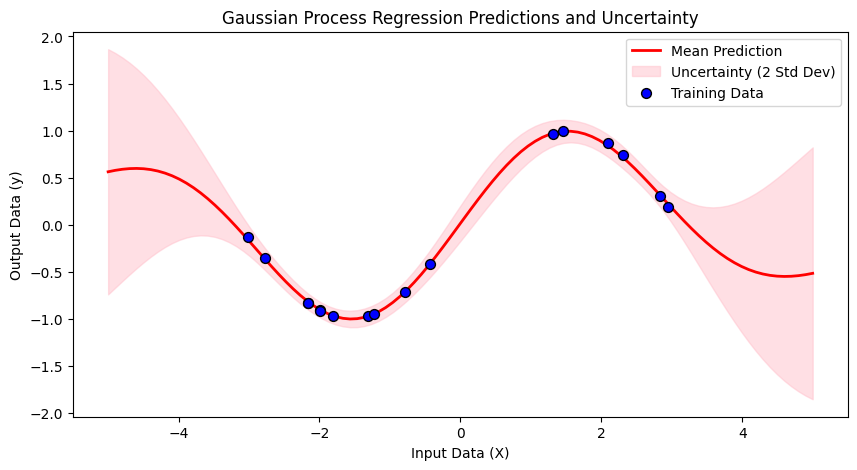

In [ ]:
# Plot the mean predictions
plt.figure(figsize=(10, 5))
plt.plot(X_test, mean, 'r', lw=2, label='Mean Prediction')

mean = mean.flatten()

# Shade the area between the mean plus two standard deviations and mean minus two standard deviations
plt.fill_between(X_test.ravel(),
                 mean - 2 * std_dev,
                 mean + 2 * std_dev,
                 color='pink', alpha=0.5, label='Uncertainty (2 Std Dev)')

# Plot the training data for reference
plt.scatter(X_train, y_train, c='blue', s=50, zorder=10, edgecolors=(0, 0, 0), label='Training Data')

# Additional plot details
plt.title('Gaussian Process Regression Predictions and Uncertainty')
plt.xlabel('Input Data (X)')
plt.ylabel('Output Data (y)')
plt.legend()
plt.show()

In [ ]:
gp_optimizer.print_parameters()

Optimized Parameters:
Length Scale: 1.65445
Signal Variance (sigma_f): 0.87517
Noise Variance (noise^2): 0.10000
Log Marginal Likelihood: -8.32977


In [ ]:
from scipy.optimize import minimize
from scipy.linalg import cholesky, solve_triangular
import numpy as np

class MultiTaskGP:
    def __init__(self, X_train, y_train, task_indices, n_tasks):
        self.X_train = X_train
        self.task_indices = task_indices
        self.n_tasks = n_tasks
        self.y_train = y_train #.repeat(n_tasks)
        self.L = None
        self.params = None
        self.B = None  # Initialize B with the identity matrix
        self.K = None

    def rbf_kernel(self, X1, X2, length_scale, sigma_f):
        sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

    # def icm_kernel(self, X1, X2, task_index_1, task_index_2, B, length_scale, sigma_f):
    #     base_kernel = self.rbf_kernel(X1, X2, length_scale, sigma_f)
    #     return base_kernel * B[task_index_1, task_index_2]

    def build_full_covariance(self, B, length_scale, sigma_f, noise, task_indices):
        # Initialize the full covariance matrix with zeros

        K_full = np.zeros((len(self.X_train), len(self.X_train)))

        # Check if all tasks are evaluated on the same data
        # if np.all(task_indices == np.arange(self.n_tasks)[:, None]):
        #     # All tasks use the same data, so we can use a simpler approach
        #     K_rbf = self.rbf_kernel(self.X_train, self.X_train, length_scale, sigma_f)
        #     K_full = np.kron(B, K_rbf)
        # else:
        #print('tasks have different data')
        # Tasks have different data, need to construct the covariance block by block
        pointer_i = 0
        for i in range(self.n_tasks):
            n_train_i = np.sum(task_indices == i)
            pointer_j = 0
            for j in range(self.n_tasks):
                n_train_j = np.sum(task_indices == j)
                # Determine the indices for the current task
                X_train_i = self.X_train[task_indices == i]
                X_train_j = self.X_train[task_indices == j]
                # Compute the RBF kernel between the data of task i and task j
                K_rbf = self.rbf_kernel(X_train_i, X_train_j, length_scale, sigma_f)

                # Combine the RBF kernel with the task covariance matrix B
                K_block = K_rbf * B[i, j]
                # Place the computed block in the full covariance matrix
                K_full[pointer_i:pointer_i+n_train_i, pointer_j:pointer_j+n_train_j] = K_block
                # Update the column pointer
                pointer_j += n_train_j

            # Update the row pointer
            pointer_i += n_train_i

        # Add noise to the diagonal elements of the covariance matrix
        K_full += np.eye(K_full.shape[0]) * noise
        self.K = K_full
        return K_full

    def log_marginal_likelihood(self, params):
        length_scale, sigma_f, noise = params[:3]
        off_diagonal_elements = params[3:]

        B = np.eye(self.n_tasks)

        # hard code for 2 tasks
        B[0,0] = off_diagonal_elements[0]
        B[1,1] = off_diagonal_elements[1]
        B[0,1] = off_diagonal_elements[2]
        B[1,0] = off_diagonal_elements[2]

        self.B = B

        self.K = self.build_full_covariance(B, length_scale, sigma_f, noise, self.task_indices)

        jitter = 1e-5
        self.L = cholesky(self.K + jitter * np.eye(self.K.shape[0]), lower=True)

        # Compute the log marginal likelihood
        S1 = solve_triangular(self.L, self.y_train.flatten(), lower=True)
        S2 = solve_triangular(self.L, S1, lower=True, trans='T')
        log_likelihood = -0.5 * np.dot(self.y_train.flatten(), S2)
        log_likelihood -= np.sum(np.log(np.diag(self.L)))
        log_likelihood -= len(self.y_train) * np.log(2 * np.pi)
        print(log_likelihood)
        return -log_likelihood

    def fit(self, initial_params):
        res = minimize(self.log_marginal_likelihood, initial_params, method='L-BFGS-B', bounds=((1e-5, None), (0.1, 5), (1e-5, None),  (0, 5), (0, 5),  (-5, 5)))
        self.params = res.x
        print("Fitted parameters:", self.params)

    def predict(self, X_test, task_index_test):
        # Ensure the Cholesky decomposition is already computed
        if self.L is None:
            raise ValueError("Model is not fitted yet. Please call the 'fit' method first.")

        # Compute the kernel matrix between test points and training points
        K_test_train = np.zeros((len(X_test), len(self.X_train)))
        length_scale, sigma_f, noise = self.params[:3]

        pointer_i = 0
        for i in range(self.n_tasks):
            # Determine the number of test points for task i
            n_test_i = np.sum(task_index_test == i)
            X_test_i = X_test[task_index_test == i]

            pointer_j = 0
            for j in range(self.n_tasks):
                # Determine the number of training points for task j
                n_train_j = np.sum(task_indices == j)
                X_train_j = self.X_train[task_indices == j]

                # Compute the RBF kernel between the data of task i (test) and task j (train)
                K_rbf = self.rbf_kernel(X_test_i, X_train_j, length_scale, sigma_f)

                # Combine the RBF kernel with the task covariance matrix B
                K_block = K_rbf * self.B[i, j]

                # Place the computed block in the K_test_train covariance matrix
                K_test_train[pointer_i:pointer_i + n_test_i, pointer_j:pointer_j + n_train_j] = K_block

                # Update the column pointer
                pointer_j += n_train_j

            # Update the row pointer
            pointer_i += n_test_i

        # Compute the kernel matrix between test points and training points
        # assumes we always predict for all tasks.
        K_test_test = np.zeros((len(X_test), len(X_test)))

        for i in range(self.n_tasks):
          for j in range(self.n_tasks):
              # Determine the indices for the current task
              X_test_i = X_test[task_index_test == i]
              X_test_j = X_test[task_index_test == j]
              # Compute the RBF kernel between the data of task i and task j
              K_rbf = self.rbf_kernel(X_test_i, X_test_j, length_scale, sigma_f)
              # Combine the RBF kernel with the task covariance matrix B
              K_block = K_rbf * self.B[i, j]
              # Place the computed block in the full covariance matrix
              K_test_test[i*len(X_test_i):i*len(X_test_i)+len(X_test_i), j*len(X_test_j):j*len(X_test_j)+len(X_test_j)] = K_block

        # Compute the mean of the predictive distribution
        # Solve for alpha
        alpha = cho_solve((self.L, True), self.y_train)

        # Predicted means
        predicted_mean = K_test_train.dot(alpha)

        v = solve_triangular(self.L, K_test_train.T, lower=True)
        mean = K_test_train.dot(solve_triangular(self.L.T, v))

        # Compute the variance at the test points
        v = cho_solve((self.L, True), K_test_train.T)
        predicted_variance = K_test_test - K_test_train.dot(v)

        # Optionally compute the predictive variance
        #K_test = self.icm_kernel(X_test, X_test, task_index_test, task_index_test, self.B, *self.params[:3])
        #variance = K_test_test - (v.T.dot(v))

        # The diagonal of the variance matrix contains the variances of the test points
        var_diagonal = np.diag(predicted_variance)
        # Ensure the variance is positive
        predicted_variance = np.maximum(var_diagonal, 0)
        return predicted_mean, predicted_variance

In [ ]:

# Generate training data for two tasks
#X_train_task1 = np.linspace(-5, 5, 25).reshape(-1, 1)
n_train_points = 20

X_train_task1 = np.random.uniform(-np.pi, np.pi, n_train_points)
X_train_task1 = np.sort(X_train_task1, axis=0).reshape(-1, 1)
y_train_task1 = np.sin(X_train_task1)

# Filter out points where x is between 0 and 1
mask = (X_train_task1 > 0) ^ (X_train_task1 < 1)
X_train_task1 = X_train_task1[mask].reshape(-1, 1)
y_train_task1 = y_train_task1[mask].reshape(-1, 1)
#print(y_train_task1)

#X_train_task2 = np.linspace(-5, 5, 25).reshape(-1, 1)
X_train_task2 = np.random.uniform(-np.pi, np.pi, n_train_points)
X_train_task2 = np.sort(X_train_task2, axis=0).reshape(-1, 1)
#X_train_task2 = X_train_task1

y_train_task2 = np.cos(X_train_task2)
#print(y_train_task2)
# Combine the training data
X_train = np.vstack((X_train_task1, X_train_task2))
y_train = np.vstack((y_train_task1, y_train_task2))

# Task indices (0 for Task 1, 1 for Task 2)
task_indices = np.array([0]*len(X_train_task1) + [1]*len(X_train_task2))

# Define the standard deviation of the noise
noise_std = 0.1

# Add normally distributed noise to the training data outputs
y_train_task1_noisy = y_train_task1 + np.random.normal(0, noise_std, y_train_task1.shape)
y_train_task2_noisy = y_train_task2 + np.random.normal(0, noise_std, y_train_task2.shape)

# Combine the noisy training data
y_train_noisy = np.vstack((y_train_task1_noisy, y_train_task2_noisy))

# The rest of your setup remains the same


# Initialize the MultiTask GP Optimizer
n_tasks = 2  # We have two tasks
mtgp_optimizer = MultiTaskGP(X_train, y_train_noisy, task_indices, n_tasks)


# # Fit the model (initial_params are length_scale, sigma_f, and noise for each task)
initial_params = [1.59443, 0.85217, 0.1, 1, 1, 0]  # Example initial parameters
mtgp_optimizer.fit(initial_params)

# Generate test data for two tasks
X_test_task1 = np.linspace(-5, 5, 30).reshape(-1, 1)  # More points for finer resolution
y_test_task1_true = np.sin(X_test_task1)  # True values without noise

X_test_task2 = np.linspace(-5, 5, 30).reshape(-1, 1)  # More points for finer resolution
y_test_task2_true = np.cos(X_test_task2)  # True values without noise

# Combine the test data
X_test = np.vstack((X_test_task1, X_test_task2))

# Task indices for the test data (0 for Task 1, 1 for Task 2)
test_task_indices = np.array([0]*len(X_test_task1) + [1]*len(X_test_task2))

# The true values are only for reference and comparison with the predictions
y_test_true = np.vstack((y_test_task1_true, y_test_task2_true))

y_test_predicted = mtgp_optimizer.predict(X_test,test_task_indices)
mean, var = y_test_predicted
mean = mean.flatten()

# length_scale, sigma_f, noise = initial_params[:3]
# off_diagonal_elements = initial_params[3:]
# print(off_diagonal_elements)

# B = np.eye(2)

# # hard code for 2 tasks
# B[0,1] = off_diagonal_elements[0]
# B[1,0] = off_diagonal_elements[1]

# print(B)


# K_check = mtgp_optimizer.build_full_covariance(B, length_scale, sigma_f, noise, task_indices)
# plt.imshow(K_check)
# plt.colorbar()

# Predict new data points for Task 1
# X_s = np.linspace(0, 5, 100).reshape(-1, 1)  # New input data
# task_index = 0  # We want to predict for Task 1
# mu_s, cov_s = mtgp_optimizer.predict(X_s, task_index)

# # The output mu_s is the mean prediction, and cov_s is the covariance of the predictions
# B = np.array([[1, 2], [0.5, 1]])

-44.124316478095864
-44.124316486988185
-44.124316481444225
-44.12431762536933
-44.12431648034845
-44.12431647726996
-44.124316477151375
-3883.9736613809837
-3883.973705551796
-3883.973647981418
-3882.196788880341
-3883.973657391289
-3883.9736608707894
-3883.9736632745635
-39.636913827431954
-39.63691381596652
-39.636913832511254
-39.6369153816602
-39.63691382830319
-39.63691382847388
-39.63691382755151
-34.212362304030314
-34.2123622497113
-34.212362297749095
-34.212364569216824
-34.21236229972345
-34.212362305357544
-34.21236230854564
-31.874688854166557
-31.874688730253567
-31.87468881026453
-31.874688086938733
-31.874688837790707
-31.874688853946303
-31.874688867990926
-32.500287987803354
-32.50028790614472
-32.500287971501706
-32.50029033326297
-32.500287980035786
-32.500287988754124
-32.50028799556446
-31.603023796413822
-31.603023685068656
-31.603023764248988
-31.60302511900435
-31.603023783635372
-31.60302379666591
-31.603023808100758
-5809.229024881281
-5809.229044716122
-5809

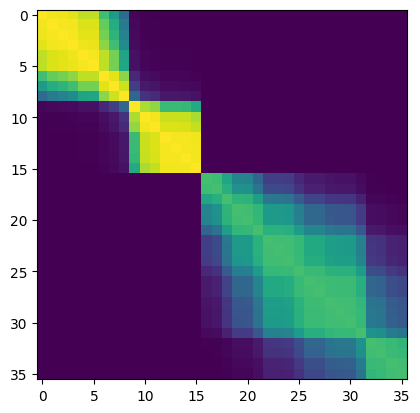

In [ ]:
plt.imshow(mtgp_optimizer.K)

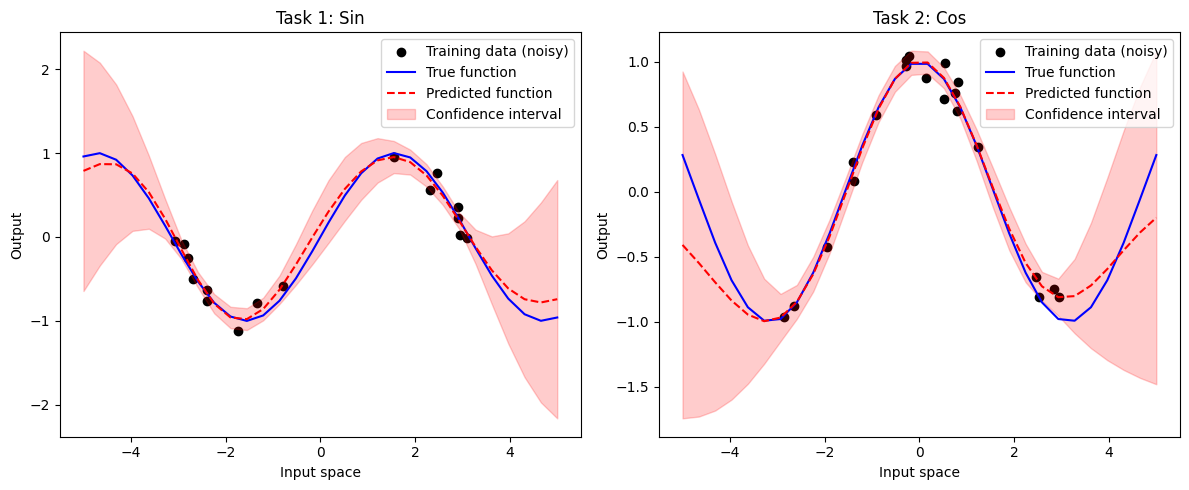

In [ ]:
import matplotlib.pyplot as plt

# Plot training data and predicted test data for Task 1
plt.figure(figsize=(12, 5))

# Subplot for Task 1
plt.subplot(1, 2, 1)
plt.scatter(X_train_task1, y_train_task1_noisy, c='k', label='Training data (noisy)')

plt.plot(X_test_task1, y_test_task1_true, 'b-', label='True function')
plt.plot(X_test_task1, mean[:30], 'r--', label='Predicted function')
plt.fill_between(X_test_task1.flatten(),
                 (mean[:30] - 1.96 * np.sqrt(var[:30])),
                 (mean[:30] + 1.96 * np.sqrt(var[:30])),
                 color='r', alpha=0.2, label='Confidence interval')
plt.title('Task 1: Sin')
plt.xlabel('Input space')
plt.ylabel('Output')
plt.legend()

# Subplot for Task 2
plt.subplot(1, 2, 2)
plt.scatter(X_train_task2, y_train_task2_noisy, c='k', label='Training data (noisy)')
plt.plot(X_test_task2, y_test_task2_true, 'b-', label='True function')
plt.plot(X_test_task2, mean[30:], 'r--', label='Predicted function')
plt.fill_between(X_test_task2.flatten(),
                 (mean[30:] - 1.96 * np.sqrt(var[30:])),
                 (mean[30:] + 1.96 * np.sqrt(var[30:])),
                 color='r', alpha=0.2, label='Confidence interval')
plt.title('Task 2: Cos')
plt.xlabel('Input space')
plt.ylabel('Output')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
